In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [304]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [240]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

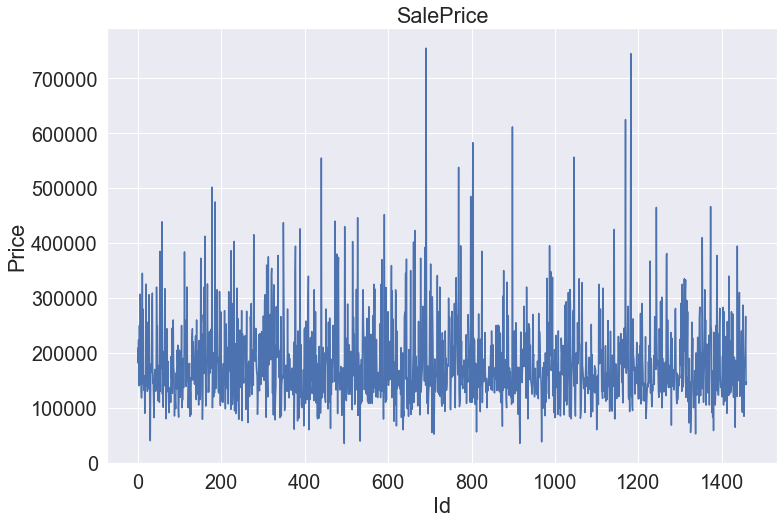

In [241]:
train.SalePrice.plot(figsize=(12,8))
plt.title('SalePrice')
plt.ylabel('Price')
plt.xlabel('Id');

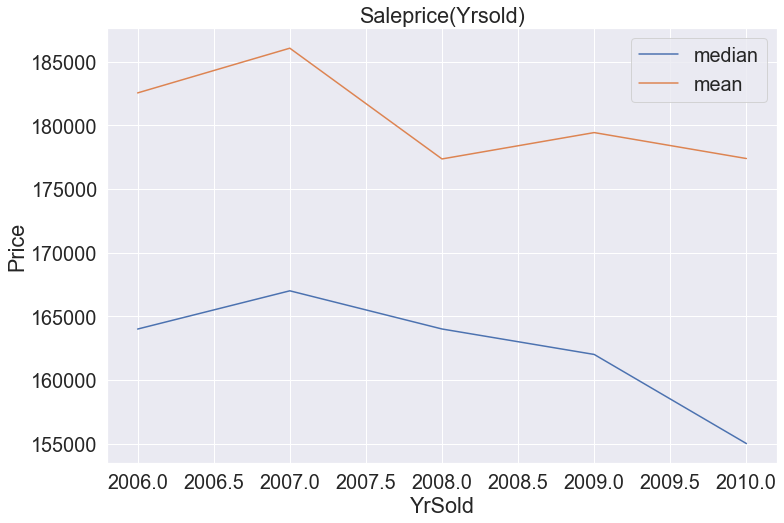

In [242]:
train.groupby('YrSold').agg([np.median,np.mean]).SalePrice.plot(figsize=(12,8))
plt.ylabel('Price')
plt.title('Saleprice(Yrsold)');

In [243]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [305]:
def cleaning_na(data):
    columns_with_na = np.where(data.isna().sum()>0)[0]
    columns_to_drop = (data.iloc[:,columns_with_na].isna().sum()/data.shape[0]*100)>40
    columns_number = columns_with_na[np.where((data.iloc[:,columns_with_na].dtypes=='float')|(data.iloc[:,columns_with_na].dtypes=='int'))[0]]
    columns_cat =  columns_with_na[np.where(data.iloc[:,columns_with_na].dtypes=='object')[0]]
    data.iloc[:,columns_number] = data.iloc[:,columns_number].apply(lambda x:x.fillna(x.median()))
    for column in columns_cat:
        data.iloc[:,column].fillna(data.iloc[:,column].mode()[0],inplace=True)
    data.drop(data.columns[columns_with_na[columns_to_drop]],axis=1,inplace=True)
    data.drop('Id',axis=1,inplace=True)
cleaning_na(train)
cleaning_na(test)
train.to_csv('train_clean.csv',index=None)
test.to_csv('test_clean.csv',index=None) 

In [245]:
corr = train.corr()

Text(0.5, 1, 'Correlation')

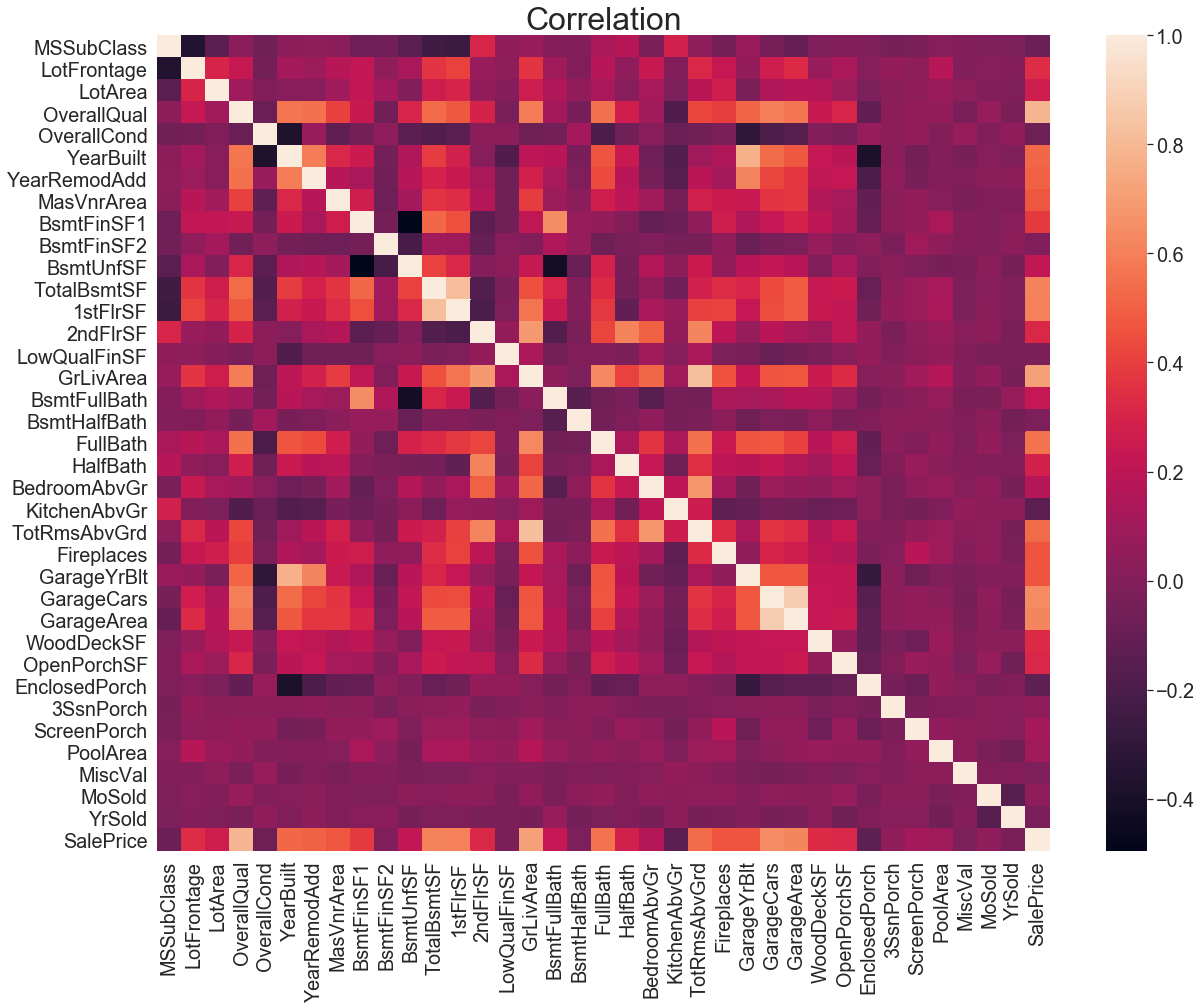

In [246]:
plt.figure(figsize=(20,15))
sns.set(font_scale=1.8)
sns.heatmap(corr)
plt.title('Correlation',fontsize=32)

In [247]:
train.groupby(['CentralAir','Electrical','Heating'])[['SalePrice']].median()

SalePrice
CentralAir Electrical Heating           
N          FuseA      GasA        106125
                      GasW        239000
                      Grav         60000
                      Wall         90200
           FuseF      GasA        105750
                      GasW         98500
                      Grav        100000
                      Wall         94000
           FuseP      GasA         82000
           SBrkr      Floor        72500
                      GasA         99000
                      GasW        133900
                      Grav         67200
                      OthW        125750
Y          FuseA      GasA        125000
                      GasW        144000
           FuseF      GasA        130000
           Mix        GasA         67000
           SBrkr      GasA        173000
                      GasW        225000

In [248]:
numeric = np.where((train.dtypes=='int')|(train.dtypes=='float'))[0]
pear = []
for col in numeric:
    pear.append(np.abs(stats.pearsonr(train.iloc[:,col],train['SalePrice'])[0]))
spear = []
for col in numeric:
    spear.append(np.abs(stats.spearmanr(train.iloc[:,col],train['SalePrice'])[0]))
print('feats with pvalue < 0.05 ','spearmanr:',(np.array(spear)<0.05).sum(),'pearson:',(np.array(pear)<0.05).sum())

feats with pvalue < 0.05  spearmanr: 4 pearson: 7


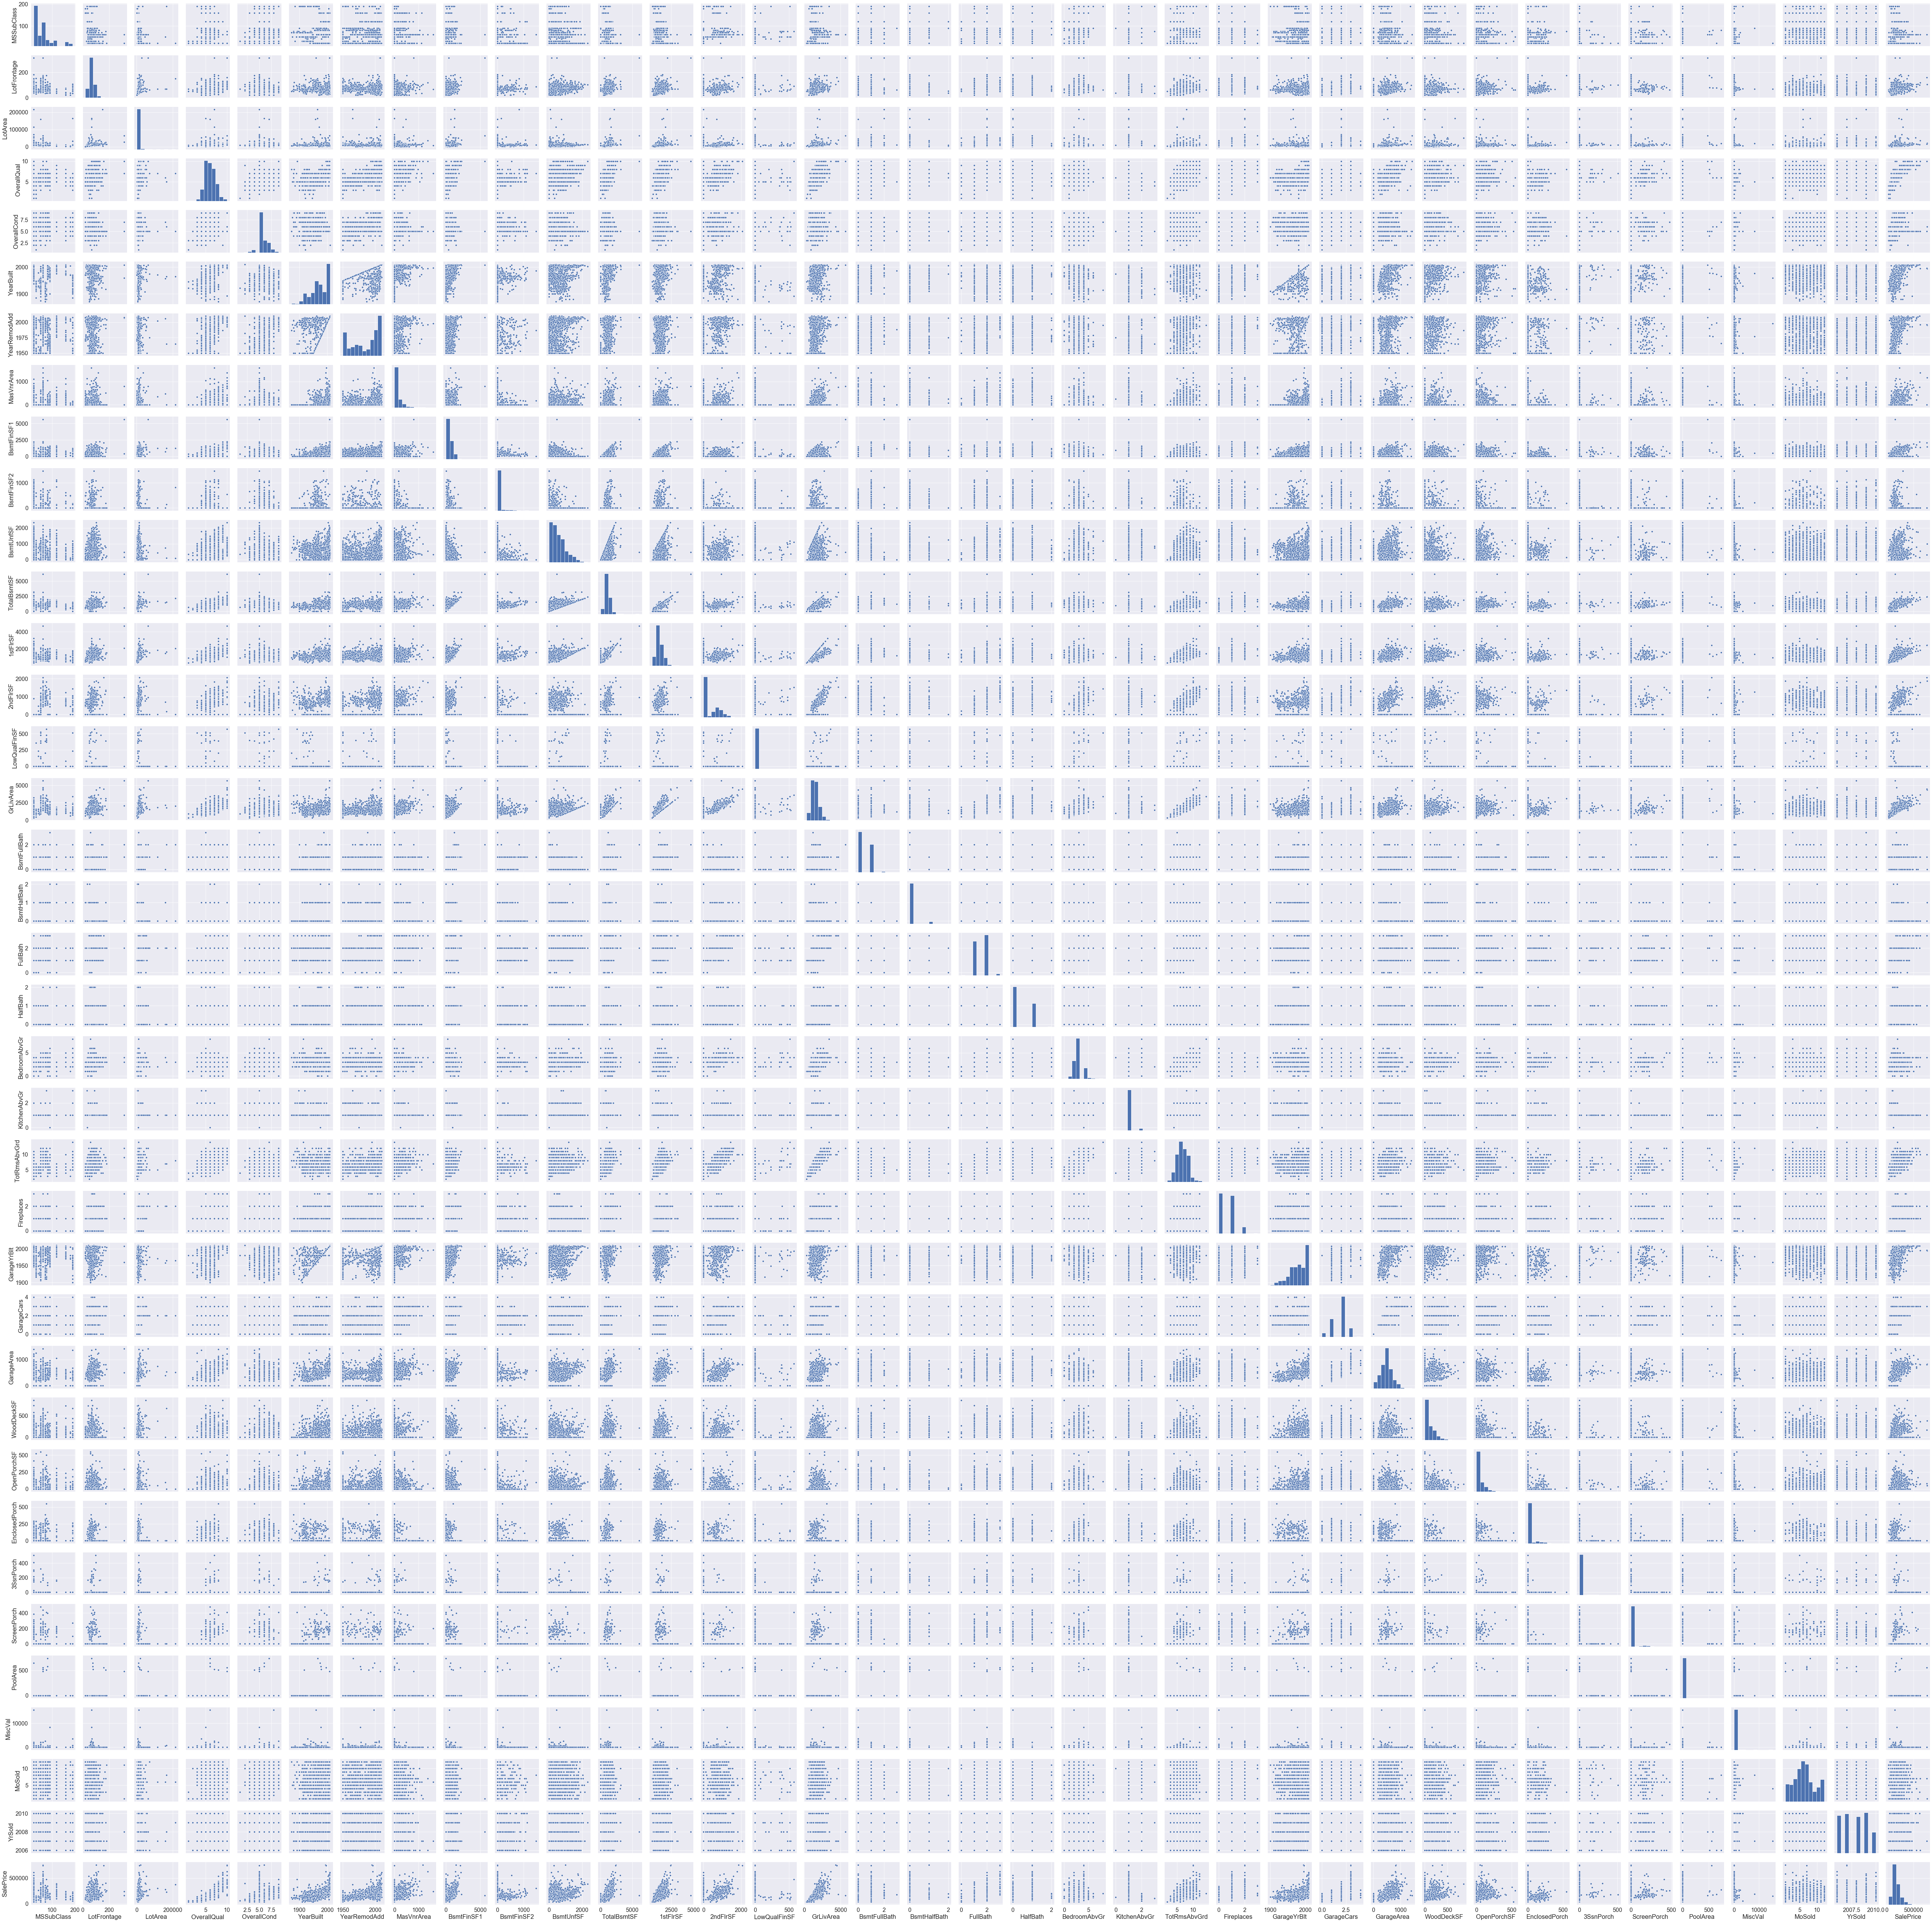

In [14]:
sns.pairplot(train.iloc[:,numeric],kind='scatter',diag_kind='kde')

In [249]:
train.rename(columns={'1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecondFlrSF','3SsnPorch':'ThirdSsnPorch'},inplace=True)
numeric = np.where((train.dtypes=='int')|(train.dtypes=='float'))[0]
feats = list(train.columns[numeric].drop('SalePrice'))
features_string = " + ".join(feats)

In [250]:
m1 = smf.ols('SalePrice ~ ' + features_string , data=train)
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     182.4
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:54:26   Log-Likelihood:                -17319.
No. Observations:                1460   AIC:                         3.471e+04
Df Residuals:                    1425   BIC:                         3.489e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.628e+05   1.41e+06      0.327

In [251]:
feats = np.array(feats)
dro = fitted.pvalues>0.65
feats[dro[1:]]

array(['BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GarageArea',
       'OpenPorchSF', 'MiscVal', 'MoSold'], dtype='<U13')

In [313]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV,LogisticRegression,RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [306]:
X = train.drop('SalePrice',axis=1)
y = train.SalePrice
categorical_cols = np.where(X.dtypes=='object')[0]
numerical_cols = np.where((X.dtypes=='float')|(X.dtypes=='int'))[0]

In [255]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', StandardScaler())
])
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [307]:
scaler = StandardScaler()
cat = OneHotEncoder(handle_unknown='ignore')

In [308]:
X.iloc[:,numerical_cols] = scaler.fit_transform(X.iloc[:,numerical_cols])
test.iloc[:,numerical_cols] = scaler.transform(test.iloc[:,numerical_cols])
X_cat = cat.fit_transform(X.iloc[:,categorical_cols])
test_cat = cat.transform(test.iloc[:,categorical_cols])

In [309]:
X.drop(X.columns[categorical_cols],axis=1,inplace=True)
test.drop(test.columns[categorical_cols],axis=1,inplace=True)

In [310]:
X = X.values
test = test.values
X = np.hstack((X,X_cat.toarray()))
test = np.hstack((test,test_cat.toarray()))

In [315]:
logit = LogisticRegression(random_state=5)
logit.fit(X,y)
logit.predict(test)

/Users/borisevich.vd/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([144000, 272000, 192000, ..., 149900, 148000, 270000])

In [ ]:
# Bundle preprocessing and modeling code in a pipeline
model = LogisticRegressionCV(random_state=5)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
my_pipeline.fit(X,y)
# Preprocessing of training data, fit model 
#print(cross_val_score(my_pipeline,X,y,cv=5))

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(test)
